# PWHL Skater Statistics for the Current Season
## Setup
Decomment any of the following lines to install the corresponding packages.

In [2]:
#!pip install html5lib
#!pip install lxml
#!pip install selenium

Import all required libraries/packages.

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

Define the webscraping function.

**NOTE:** A WebDriver must be installed for this to work. See [Selenium’s download page](https://www.selenium.dev/downloads/) for details. If not using Edge, edit the third line of the following cell.

In [6]:
def scrape_stats_page(url):
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge
    # open the webpage
    driver.get(url)
    # wait for the table to load
    try:
        table = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, '//table'))
        )
        rows = table.find_elements(By.TAG_NAME, 'tr')
        data = []
        for row in rows:
            cols = row.find_elements(By.TAG_NAME, 'td')
            data.append([col.text for col in cols])
        df = pd.DataFrame(data)
    finally:
        driver.quit()
    return df

Define team names, location, codes and colors.

In [8]:
teams = {"BOS": {"name": "Fleet", "location": "Boston", "code": "BOS", "color":"#173f35"},
         "MIN": {"name": "Frost", "location": "Minnesota", "code": "MIN", "color":"#251161"},
         "MTL": {"name": "Victoire", "location": "Montréal", "code": "MTL", "color":"#832434"},
         "NY": {"name": "Sirens", "location": "New York", "code": "NY", "color":"#00bcb5"},
         "OTT": {"name": "Charge", "location": "Ottawa", "code": "OTT", "color":"#a3142f"},
         "TOR": {"name": "Sceptres", "location": "Toronto", "code": "TOR", "color":"#1869b7"}}

## Player rankings data
### Webscraping
The page doesn’t load the table immediately so there is a delay before scraping the data. Wait for the completion message before trying to use `df`.

In [10]:
for i in range (1, 8):
    page_url = "https://www.thepwhl.com/en/stats/player-stats/all-teams/5?sort=points&playertype=skater&position=skaters&rookie=no&statstype=expanded&page=" + str(i) + "&league=1"
    page_df = scrape_stats_page(page_url)
    if ("temp_df" not in globals()):
        temp_df = page_df
    else:
        temp_df = pd.concat([temp_df, page_df])
df = temp_df
del temp_df
print("Webscraping complete.")

Webscraping complete.


### Dataframe cleaning and formatting

In [12]:
df.columns = ["rank", "status", "photo", "name", "position",
              "team", "games_played", "goals", "assists", "points",
              "plus/minus", "penalty minutes", "power play goals", "power play assists", "short handed goals",
              "shots", "short handed assists", "game winning goals", "first goals", "insurance goals",
              "overtime goals", "unassisted goals", "empty net", "shooting percentage", "shootout goals",
              "shots in shootouts", "shootoutwinning goals", "shootout percentage", "nothing"]
df.drop(columns=["photo", "nothing", "position"], inplace=True) #photo and nothing are just blank spaces in the table; the photos are loaded separately
                                                                #the position is covered by the other table
#changing format to numeric
numeric_cols = df.columns.drop(["status", "name", "team"])
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
#removing blank lines
df.dropna(inplace = True)

# The status column contains an asterisk for a rookie and an X for an inactive player
# Changing them to words for clarity
pd.options.mode.copy_on_write = True
is_rookie = (df["status"] == "*")
is_inactive = (df["status"] == "x")
df.loc[is_rookie, "status"] = "rookie"
df.loc[is_inactive, "status"] = "inactive"
# Players who switched teams during the season have " +" after their name
# Removing " +"
df["name"] = df["name"].str.replace(" +", "")
df

,rank,status,name,team,games_played,goals,assists,points,plus/minus,penalty minutes,...,first goals,insurance goals,overtime goals,unassisted goals,empty net,shooting percentage,shootout goals,shots in shootouts,shootoutwinning goals,shootout percentage
1,1.0,,Claire Thompson,MIN,7.0,1.0,9.0,10.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,8.3,0.0,0.0,0.0,0.0
3,2.0,,Alex Carpenter,NY,6.0,4.0,4.0,8.0,4.0,0.0,...,0.0,0.0,1.0,1.0,0.0,26.7,1.0,1.0,0.0,100.0
5,3.0,rookie,Sarah Fillier,NY,6.0,3.0,5.0,8.0,3.0,2.0,...,1.0,0.0,0.0,0.0,0.0,15.8,0.0,1.0,0.0,0.0
7,4.0,,Hilary Knight,BOS,7.0,4.0,3.0,7.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,17.4,0.0,0.0,0.0,0.0
9,5.0,,Kendall Coyne Schofield,MIN,7.0,3.0,4.0,7.0,4.0,0.0,...,1.0,0.0,0.0,1.0,0.0,15.8,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,136.0,,Jessica Digirolamo,BOS,7.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,137.0,,Savannah Harmon,TOR,7.0,0.0,0.0,0.0,-3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,138.0,,Rebecca Leslie,OTT,7.0,0.0,0.0,0.0,-3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,139.0,,Hayley Scamurra,TOR,7.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Player details data
### Webscraping
The page doesn’t load the table immediately so there is a delay before scraping the data. Wait for the completion message before trying to use `det_df`.

In [14]:
for i in range (1, 7):
    page_url = "https://www.thepwhl.com/en/stats/roster/" + str(i) + "/5?league=1"
    page_df = scrape_stats_page(page_url)
    if ("temp_df" not in globals()):
        temp_df = page_df
    else:
        temp_df = pd.concat([temp_df, page_df])
det_df = temp_df
del temp_df
print("Webscraping complete.")

Webscraping complete.


### Dataframe cleaning and formatting

In [16]:
det_df.columns = ["jersey number", "name", "position", "shoots", "date of birth", "home town", "nothing"]
det_df.drop(columns=["nothing"], inplace=True) #this one is just blank space in the table
det_df.dropna(inplace = True) #removing blank lines
det_df = det_df[det_df["position"] != "G"] #removing goalies

In [17]:
# Boston gives more specific values for the position, like "LW" for "left wing" or "C" for "center"
# Changing them all to "F" for forward and "D" for defense to match the other teams
pd.options.mode.copy_on_write = True
forward = det_df["position"].isin(["F", "RW", "C", "LW"])
defense = det_df["position"].isin(["D", "RD", "LD"])
det_df.loc[forward, "position"] = "forward"
det_df.loc[defense, "position"] = "defense"
det_df

,jersey number,name,position,shoots,date of birth,home town
2,8,Kelly Babstock,forward,R,1992-08-04,"Mississauga, ON"
3,9,Sophie Shirley,forward,R,1999-06-30,"Saskatoon, SK"
4,11,Alina Müller,forward,L,1998-03-12,"Winterthur, SWI"
5,14,Jillian Dempsey,forward,L,1991-01-19,"Winthrop, MA"
6,16,Amanda Pelkey,forward,R,1993-05-29,"Montpelier, VT"
...,...,...,...,...,...,...
23,12,Allie Munroe,defense,L,1997-04-20,"Yarmouth, NS"
24,14,Renata Fast,defense,R,1994-10-06,"Burlington, ON"
25,19,Lauren Bernard,defense,L,2001-07-15,"Madison, OH"
26,23,Megan Carter,defense,L,2001-05-23,"Milton, ON"


## Joining dataframes and saving to CSV

In [19]:
skaters_df = df.merge(det_df, on="name")
skaters_df

,rank,status,name,team,games_played,goals,assists,points,plus/minus,penalty minutes,...,shooting percentage,shootout goals,shots in shootouts,shootoutwinning goals,shootout percentage,jersey number,position,shoots,date of birth,home town
0,1.0,,Claire Thompson,MIN,7.0,1.0,9.0,10.0,2.0,2.0,...,8.3,0.0,0.0,0.0,0.0,42,defense,L,1998-01-28,"Toronto, ON"
1,2.0,,Alex Carpenter,NY,6.0,4.0,4.0,8.0,4.0,0.0,...,26.7,1.0,1.0,0.0,100.0,25,forward,L,1994-04-13,"North Reading, MA"
2,3.0,rookie,Sarah Fillier,NY,6.0,3.0,5.0,8.0,3.0,2.0,...,15.8,0.0,1.0,0.0,0.0,10,forward,R,2000-08-31,"Georgetown, ON"
3,4.0,,Hilary Knight,BOS,7.0,4.0,3.0,7.0,1.0,2.0,...,17.4,0.0,0.0,0.0,0.0,21,forward,R,1989-07-12,"Sun Valley, ID"
4,5.0,,Kendall Coyne Schofield,MIN,7.0,3.0,4.0,7.0,4.0,0.0,...,15.8,0.0,0.0,0.0,0.0,26,forward,L,1992-05-25,"Palos Heights, IL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136.0,,Jessica Digirolamo,BOS,7.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,22,defense,L,1999-02-13,"Mississauga, ON"
123,137.0,,Savannah Harmon,TOR,7.0,0.0,0.0,0.0,-3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,defense,L,1995-10-27,"Downers Grove, IL"
124,138.0,,Rebecca Leslie,OTT,7.0,0.0,0.0,0.0,-3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,37,forward,R,1996-05-08,"Ottawa, ON"
125,139.0,,Hayley Scamurra,TOR,7.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,1.0,0.0,0.0,16,forward,L,1994-12-14,"Buffalo, NY"


In [20]:
skaters_df.to_csv("skater_stats.csv", index=False)

## Example visualization: points per rookie per team

In [22]:
def points_per_rookie(df, team_code):
    rookie_points = (df[(df["status"] == "rookie") & (df["team"] == team_code)])["points"] #only keeps the rookies from the specified team
    return rookie_points.sum() / rookie_points.count() # total points divided by number of rookies

colors = []
pprookie_data = []

# creating the colors and pprookie_data lists
for team, details in teams.items():
    pprookie_data.append((team, points_per_rookie(skaters_df, team)))
    colors.append(details["color"])

# turning the pprookie_data list into a DataFrame
pprookie_df = pd.DataFrame(pprookie_data)
# naming the columns
pprookie_df.columns = ["team", "points per rookie"]
pprookie_df

,team,points per rookie
0,BOS,2.250000
1,MIN,1.625000
2,MTL,1.400000
3,NY,2.833333
4,OTT,2.333333
5,TOR,1.333333


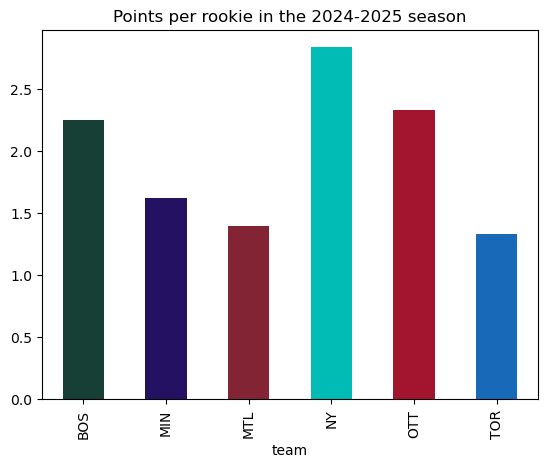

In [23]:
pprookie_df.plot.bar(x="team", y="points per rookie", color=colors, title="Points per rookie in the 2024-2025 season", legend=None)
plt.show()

## Notes

* The number of rows in the output file may vary as players may join the league during the season.
* The highest player rank may be higher than the number of rows in the CSV file as goalies may also score points and obtain a rank, but are removed from this dataset.